# Circulation
This plots the stream function when monsoon is occuring in summer, and just prior to this at the equinox.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
# Use custom matplotlib style for publishing
plt.style.use(os.environ['PWD']+'/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
# matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [2]:
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.constants import g, R, radius_earth, c_p
from isca_tools.utils import area_weighting, annual_time_slice
from isca_tools.utils.ds_slicing import annual_mean
from isca_tools.utils.circulation import get_stream

In [3]:
# Load dataset - at surface and in free troposphere
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

# Load dataset
exp_dir = 'rossbypalooza/lat_10/1'                # land with fixed SST
time_start = 100
# exp_dir = 'rossbypalooza/depth=20/lat_10/base'                # land with fixed SST
# time_start = 0
# exp_dir = 'tau_sweep/aquaplanet/depth=1/k=1'       # aquaplanet
# time_start = 360*2                                  # skip first 2 years for aquaplanet when allow to spin up

# only keep variables required to compute relative humidity and MSE
var_keep = ['ucomp', 'vcomp', 'omega', 'temp', 'height', 'precipitation', 'sphum', 't_surf']
# time_ind_start = 0  

# time_ind_final = 1467       # so both experiments are of same length
time_final = np.inf

ds_use = isca_tools.load_dataset(exp_dir).sel(time=slice(time_start, time_final))[var_keep]
# ds_use = annual_time_slice(ds_use, include_months=[12,1,2]).mean(dim=['time', 'lon'])
ds = {}
days_pre = np.arange(81, 101)+34
days_monsoon = np.arange(161, 181)+34
# days_pre = np.concatenate((np.arange(30), np.arange(330, 360)))
# days_pre = np.arange(330, 360)
# days_monsoon = np.arange(5*30, 6*30)
with tqdm(total=2, position=0, leave=True) as pbar:
    # ds['ONDJFM'] =  annual_time_slice(ds_use, include_months=[10,11,12,1,2,3]).mean(dim=['time', 'lon']).load()
    ds['prior'] =  annual_time_slice(ds_use, include_days=days_pre).mean(dim=['time', 'lon']).load()
    pbar.update(1)
    # ds['JJA'] = annual_time_slice(ds_use, include_months=[6,7,8]).mean(dim=['time', 'lon']).load()
    ds['monsoon'] =  annual_time_slice(ds_use, include_days=days_monsoon).mean(dim=['time', 'lon']).load()
    pbar.update(1)

namelist = isca_tools.load_namelist(exp_dir)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau_sw = namelist['two_stream_gray_rad_nml']['atm_abs']
tau_lw = namelist['two_stream_gray_rad_nml']['odp']
try:
    omega = namelist['constants_nml']['omega']
except KeyError:
    omega = 7.2921150e-05  # default earth value
     
pfull = ds_use.pfull
n_pressure = len(pfull)

100%|██████████| 2/2 [00:05<00:00,  2.61s/it]


In [4]:
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(pfull)), pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [5]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
keys_season = list(ds.keys())
colors_season = {keys_season[i]: default_colors[i] for i in range(len(keys_season))}
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [6]:
p_upper_cell = 300
ind_upper_cell = int(np.abs(pfull - p_upper_cell).argmin())
ind_surf = int(np.abs(pfull - 999999999999).argmin())
color_land = 'g'
lw_land = 4

lat_lims_plot = [-45, 45]

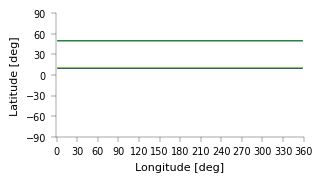

In [7]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lat_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[0]       # get the longitude coordinates of land
    lat_land_min = float(lat_land.min())
    lat_land_max = float(lat_land.max())
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)
else:
    lat_land_min = None
    lat_land_max = None
    
def show_land(ax, lat_land_min=lat_land_min, lat_land_max=lat_land_max, lat_ax='x', color_land='g', lw_land=4):
    if is_land_data:
        if not isinstance(ax, (list, np.ndarray)):
            raise ValueError(f'ax should be a list or numpy array, but given is {type(ax)}')
        for i in range(len(ax)):
            if lat_ax == 'x':
                var = ax[i].get_ylim()[0]
                xlim = ax[i].get_xlim()
                ax[i].hlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
                ax[i].set_ylim(var, ax[i].get_ylim()[1])
                ax[i].set_xlim(xlim)
            elif lat_ax == 'y':
                var = ax[i].get_xlim()[0]
                ylim = ax[i].get_ylim()
                ax[i].vlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
                ax[i].set_xlim(var, ax[i].get_xlim()[1])
                ax[i].set_ylim(ylim)
            else:
                raise ValueError(f'lat_ax must be either x or y, but {lat_ax} was given.')

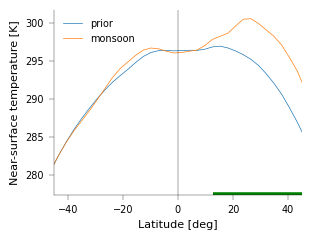

In [8]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for key in ds:
    ds[key].temp.sel(lat=slice(lat_lims_plot[0]-5, lat_lims_plot[1]+5)).isel(pfull=ind_surf).plot(ax=ax, label=key)
show_land([ax])
ax.axvline(0, color='k', lw=ax_linewidth)
ax.set_ylabel('Near-surface temperature [K]')
ax.set_title(None)
ax.set_xlabel('Latitude [deg]')
ax.set_xlim(lat_lims_plot)
ax.legend();

## Wind Reversal

Text(0, 0.5, '$v$ [m/s]')

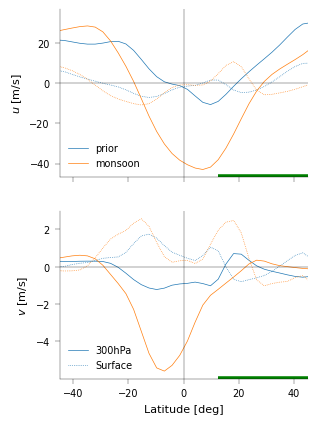

In [9]:
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for key in ds:
    ax[0].plot(ds[key].lat, ds[key].ucomp.isel(pfull=ind_upper_cell), color=colors_season[key], label=key)
    ax[0].plot(ds[key].lat, ds[key].ucomp.isel(pfull=ind_surf), color=colors_season[key], linestyle=':')
    ax[1].plot(ds[key].lat, ds[key].vcomp.isel(pfull=ind_upper_cell), color=colors_season[key], 
               label=f'{p_upper_cell}hPa' if key==list(ds.keys())[0] else None)
    ax[1].plot(ds[key].lat, ds[key].vcomp.isel(pfull=ind_surf), color=colors_season[key], linestyle=':', 
               label='Surface' if key==list(ds.keys())[0] else None)
for i in range(len(ax)):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
    ax[i].axvline(0, color='k', lw=ax_linewidth)
show_land(ax)
ax[0].legend()
ax[1].legend()
ax[0].set_xlim(lat_lims_plot)
ax[1].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('$u$ [m/s]')
ax[1].set_ylabel('$v$ [m/s]')

Text(0, 0.5, 'Latitude [deg]')

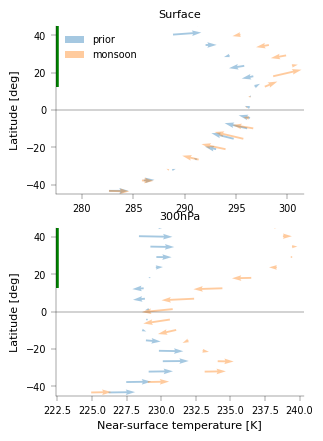

In [10]:
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharey=True)
for i, key in enumerate(ds):
    ds_use = ds[key].isel(pfull=ind_surf).sel(lat=slice(lat_lims_plot[0]-5, lat_lims_plot[1]+5))
    # im = ax[i].pcolormesh(ds_use.lon, ds_use.lat, ds_use.temp)
    
    pu, pv = (ds_use.ucomp)[::2], (ds_use.vcomp)[::2]
    ax[0].quiver(ds_use.temp[::2], ds_use.lat[::2], pu, pv, alpha=0.4, color=colors_season[key], label=key)

    ds_use = ds[key].isel(pfull=ind_upper_cell)
    pu, pv = (ds_use.ucomp)[::2], (ds_use.vcomp)[::2]
    ax[1].quiver(ds_use.temp[::2], ds_use.lat[::2], pu, pv, alpha=0.4, color=colors_season[key])

ax[0].set_title('Surface')
ax[1].set_title(f'{p_upper_cell}hPa')
for i in range(len(ax)):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
show_land(ax, lat_ax='y')
ax[0].legend()
ax[1].set_ylim(lat_lims_plot)
ax[1].set_xlabel('Near-surface temperature [K]')
ax[0].set_ylabel('Latitude [deg]')
ax[1].set_ylabel('Latitude [deg]')

## Streamfunction


In [11]:
n_lat = ds[keys_season[0]].lat.size
stream = {key: np.zeros((n_pressure, n_lat)) for key in ds}
cos_lat = np.asarray(np.cos(np.deg2rad(ds[keys_season[0]].lat)))
ang_mom = {key: np.asarray((ds[key].ucomp + omega * radius_earth * cos_lat) * radius_earth * cos_lat) for key in ds}
for key in ds:
    for i in range(n_pressure):
        # integrate from surface each time, hence weird indexing
        stream[key][ind_surf-i] = integrate.simpson(ds[key].vcomp[ind_surf-i:ind_surf+1], ds[key].pfull[ind_surf-i:ind_surf+1] * 100, axis=0)
        stream[key][ind_surf-i] = 2 * np.pi * radius_earth * cos_lat[np.newaxis] / g * stream[key][ind_surf-i]  # get into correct units of kg/s

Text(0, 0.5, 'Pressure [hPa]')

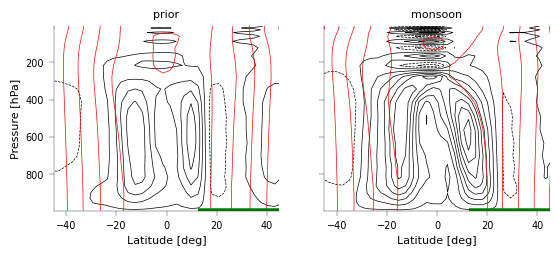

In [12]:
fig, ax = plt.subplots(1,2, figsize=(2*width['one_col'], width['one_col']/ar), sharey=True, sharex=True)
# if n_exp == 1:
#     ax = [ax]
# for i in range(n_exp):
step_level = omega * radius_earth**2 / 10
levels_ang_mom = np.arange(np.min([ang_mom[key].min() for key in ang_mom]), np.max([ang_mom[key].max() for key in ang_mom]) + step_level, 
                           step_level)
step_level = 50e9/2
levels_stream = np.arange(-np.max([np.abs(stream[key]).max() for key in ang_mom]), 
                          np.max([np.abs(stream[key]).max() for key in ang_mom]) + step_level, step_level)
for i, key in enumerate(ds):
    ax[i].contour(ds[key].lat, ds[key].pfull, stream[key], colors='k', levels = levels_stream)
    ax[i].contour(ds[key].lat, ds[key].pfull, ang_mom[key], colors='r', levels = levels_ang_mom)
    ax[i].set_title(key)
ax[0].invert_yaxis()
show_land(ax)
# ax[0].invert_yaxis()
ax[0].set_xlim(lat_lims_plot)
ax[0].set_xlabel('Latitude [deg]')
ax[1].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('Pressure [hPa]')

In [13]:
ds_annual_mean = annual_mean(isca_tools.load_dataset(exp_dir).sel(time=slice(time_start, time_final))[var_keep].mean(dim='lon')).load()

100%|██████████| 12/12 [00:00<00:00, 31.38it/s]


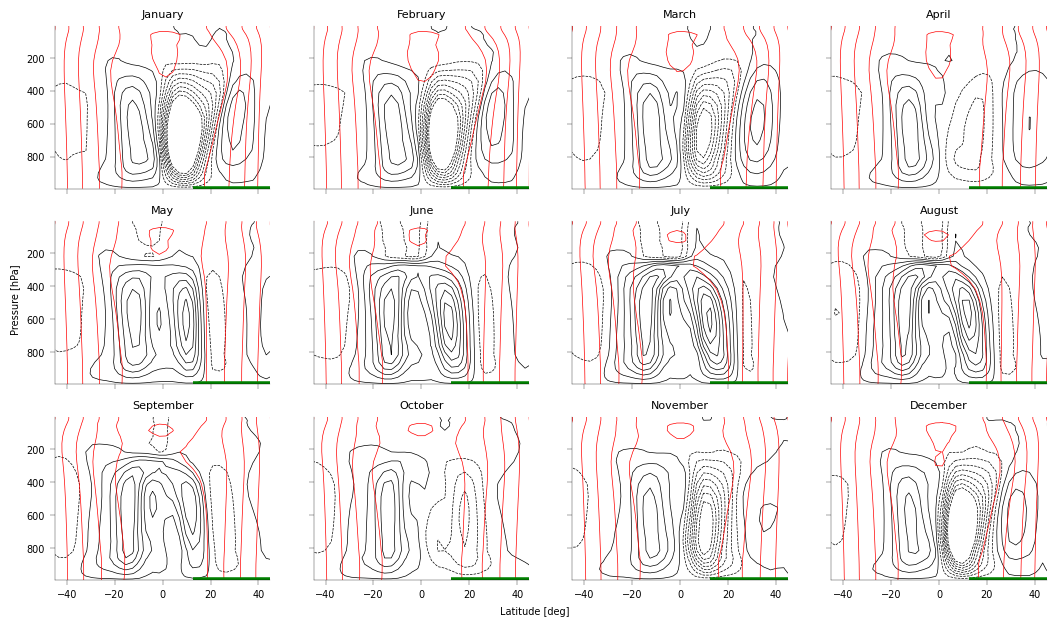

In [14]:
month_names = ['January','February','March','April','May','June','July','August','September','October','November','December']

fig, ax = plt.subplots(3,4, figsize=(4*width['one_col'], 3*width['one_col']/ar), sharex=True, sharey=True)
ax = ax.flatten()
for i in tqdm(range(len(month_names))):
    # ds['ONDJFM'] =  annual_time_slice(ds_use, include_months=[10,11,12,1,2,3]).mean(dim=['time', 'lon']).load()
    ds_plot =  annual_time_slice(ds_annual_mean, include_months=[i+1]).mean(dim=['time']).load()
    ang_mom_plot = np.asarray((ds_plot.ucomp + omega * radius_earth * cos_lat) * radius_earth * cos_lat)
    stream_plot = np.zeros((n_pressure, n_lat))
    for j in range(n_pressure):
        # integrate from surface each time, hence weird indexing
        stream_plot[ind_surf-j] = get_stream(ds_plot.vcomp.isel(pfull=np.arange(ind_surf, ind_surf-j-1, -1)), 
                                    ds_plot.vcomp.isel(pfull=np.arange(ind_surf, ind_surf-j-1, -1)).pfull*100, ds_plot.lat)
        # stream_plot[ind_surf-j] = integrate.simpson(ds_plot.vcomp[ind_surf-j:ind_surf+1], ds_plot.pfull[ind_surf-j:ind_surf+1] * 100, axis=0)
        # stream_plot[ind_surf-j] = 2 * np.pi * radius_earth * cos_lat / g * stream_plot[ind_surf-j]  # get into correct units of kg/s
    ax[i].contour(ds_plot.lat, ds_plot.pfull, stream_plot, colors='k', levels = levels_stream)
    ax[i].contour(ds_plot.lat, ds_plot.pfull, ang_mom_plot, colors='r', levels = levels_ang_mom)
    ax[i].set_title(month_names[i])
fig.supxlabel('Latitude [deg]', fontsize=7, y=0.06)
fig.supylabel('Pressure [hPa]', fontsize=7, x=0.09)
ax[0].invert_yaxis()
ax[0].set_xlim(lat_lims_plot)
show_land(ax)

In [15]:
n_day_av = 10
days_plot = np.arange(1, 361)
n_year_days = 360
n_frames = len(days_plot)
gif_info = {'stream': np.zeros((n_frames, n_pressure, n_lat)), 'omega': np.zeros((n_frames, n_pressure, n_lat)), 
            'precipitation': np.zeros((n_frames, n_lat)), 'mse': np.zeros((n_frames, n_lat)), 't_surf': np.zeros((n_frames, n_lat))}
gif_ax_lims = {key: np.zeros(2) for key in gif_info}
for i in tqdm(range(n_frames)):
    days_use = np.arange(days_plot[i]-n_day_av, days_plot[i]+n_day_av+1) % n_year_days
    days_use[days_use==0] = n_year_days
    ds_plot = annual_time_slice(ds_annual_mean, include_days=days_use).mean(dim='time')
    for j in range(n_pressure):
        # integrate from surface each time, hence weird indexing
        gif_info['stream'][i, ind_surf-j] = get_stream(ds_plot.vcomp.isel(pfull=np.arange(ind_surf, ind_surf-j-1, -1)), 
                                                       ds_plot.vcomp.isel(pfull=np.arange(ind_surf, ind_surf-j-1, -1)).pfull*100, ds_plot.lat)
    gif_info['omega'][i] = ds_plot.omega
    ds_plot = ds_plot.isel(pfull=ind_surf)
    gif_info['precipitation'][i] = ds_plot.precipitation
    gif_info['mse'][i] = moist_static_energy(ds_plot.temp, ds_plot.sphum, ds_plot.height)*1000/c_p
    gif_info['t_surf'][i] = ds_plot.t_surf
for key in gif_info:
    if key in ['stream', 'omega']:
        gif_ax_lims[key][0] = -np.abs(gif_info[key]).max()
        gif_ax_lims[key][1] = -gif_ax_lims[key][0]
    elif key=='precipitation':
        gif_ax_lims[key][0] = 0
        gif_ax_lims[key][1] = np.abs(gif_info[key]).max()
    else:
        gif_ax_lims[key][0] = gif_info[key].min()
        gif_ax_lims[key][1] = gif_info[key].max()
step_level = 50e9/2
levels_stream = np.arange(gif_ax_lims['stream'][0],
                          gif_ax_lims['stream'][1]  + step_level, step_level)

100%|██████████| 360/360 [00:07<00:00, 46.82it/s]


In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True, height_ratios=[3, 1])
stream_step = 50e9/2
ax2 = ax[1].twinx()
ax2.spines.right.set_visible(True)
ax2.spines.right.set_color(default_colors[0])
ax2.spines.left.set_visible(False)
ax2.spines.bottom.set_visible(False)
ax2.tick_params(axis='y', colors=default_colors[0])
ax[1].spines.left.set_color(default_colors[3])
ax[1].tick_params(axis='y', colors=default_colors[3])
ax = np.append(ax, ax2)
cbar_ax = fig.add_axes([0.9, 0.36, 0.01, 0.5])     # add axes for colorbar

def animate(n, fig, var_info, var_ax_lims, stream_step, lat, pfull):
    levels_stream = np.arange(var_ax_lims['stream'][0], var_ax_lims['stream'][1]  + stream_step, stream_step)
    ax = fig.axes
    ax[0].clear() 
    im = ax[0].pcolormesh(lat, pfull, var_info['omega'][n], 
                          cmap='bwr', shading='gouraud', vmin=var_ax_lims['omega'][0], vmax=var_ax_lims['omega'][1], alpha=0.8)
    if n==0:
        fig.colorbar(im, cax=cbar_ax, label='$\omega$ [Pa/s]', aspect=100, pad=0.01, fraction=0.01)
    ax[0].contour(lat, pfull, var_info['stream'][n], colors='k', levels=levels_stream, alpha=0.4)
    ax[0].invert_yaxis()
    
    ax[1].clear() 
    ax[1].plot(lat, var_info['mse'][n], color=default_colors[3], label='MSE')
    ax[1].plot(lat, var_info['t_surf'][n], color=default_colors[3], linestyle=':', label='$T_s$')
    ax[1].set_ylim(var_ax_lims['mse'][0], var_ax_lims['mse'][1])
    ax[1].legend(loc='upper left')
    show_land(ax)
    ax[2].clear()
    ax[2].plot(lat, var_info['precipitation'][n]*1000)
    ax[2].set_ylim(var_ax_lims['precipitation'][0]*1000, var_ax_lims['precipitation'][1]*1000)
    
    # Axis labels
    ax[0].set_ylabel('Pressure [hPa]')
    ax[1].set_xlabel('Latitude [deg]')
    ax[1].set_ylabel('MSE / Temperature [K]', color=default_colors[3])
    ax[2].set_ylabel('Precipitation [gm$^{-2}$s$^{-1}$]', color=default_colors[0])
    ax[0].set_title(f'{month_names[int(np.floor(n/30))]} {n%30+1}')

anim = FuncAnimation(fig, animate, frames=n_frames, interval=100,
                     blit=False, repeat_delay=200, fargs=(fig, gif_info, gif_ax_lims, stream_step, ds_plot.lat, pfull))
# plt.close()
HTML(anim.to_jshtml())


Animation size has reached 20985364 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


In [17]:
# Save animation
writervideo = matplotlib.animation.PillowWriter(fps=6) 
anim.save(f'/Users/joshduffield/Desktop/stream.gif' , writer=writervideo)